# ExpressPrint: A Tool to Watermark Visual Foundation Models
Tool Demonstration Notebook for ASE 2025

In [1]:
import warnings

warnings.filterwarnings('ignore')

import timm
import torch.nn as nn
from PIL import Image
from torchvision.transforms import Compose

from expressprint.datasets import ImageNetDataLoader, WatermarkDataLoader
from expressprint.methods import ActivationsAnalyzer, ExpressPrintWatermarker
from expressprint.models import BaseModel, create_wm_models
from expressprint.trainers import ExpressPrintTrainer

WATERMARK_SIZE = 32
BATCH_SIZE = 16
NUM_WORKERS = 4

## ⚙️ Model Compatibility

To use a custom Vision Transformer (ViT) model with ExpressPrint, you must implement a wrapper class that inherits from `BaseModel`.

This class should implement the following methods:

- `build_model(self, **kwargs)`:  
  Returns a pretrained ViT model (e.g., CLIP or DINOv2) as a `torch.nn.Module`.

- `get_blocks(self, **kwargs)`:  
  Returns a list of internal transformer blocks (used for activation analysis and signature injection).

- `get_hidden_size(self, **kwargs)`:   
  Returns the dimensionality of the internal hidden representations (used in the encoder and decoder networks).

- `get_data_transforms(self) -> tuple[Compose, Compose]`  
  Returns two `torchvision.transforms.Compose` objects:  
  **(train_transforms, val_transforms)** for image preprocessing during training and evaluation.

In [2]:
class CLIPModel(BaseModel):
    def __init__(self) -> None:
        super().__init__(model_name="OpenAI CLIP")
        self.hidden_size = 1024

    def build_model(self) -> None:
        return timm.create_model("vit_large_patch14_clip_224.openai", pretrained=True)

    def get_blocks(self) -> list[nn.Module]:
        return self.model.blocks

    def get_hidden_size(self) -> int:
        return self.hidden_size

    def get_data_transforms(self) -> tuple[Compose, Compose]:
        data_config = timm.data.resolve_model_data_config(self.model)
        train_transform = timm.data.create_transform(**data_config, is_training=True)
        val_transform = timm.data.create_transform(**data_config, is_training=False)
        return train_transform, val_transform
    
model = CLIPModel()

dataloader = ImageNetDataLoader(data_dir="../../imagenet/ILSVRC/Data/CLS-LOC")
train_transforms, val_transform = model.get_data_transforms()
dataset = dataloader.get_val_dataset(val_transform)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.54it/s]


📌 Selected expressive block: 12 (based on top-5 activation change)


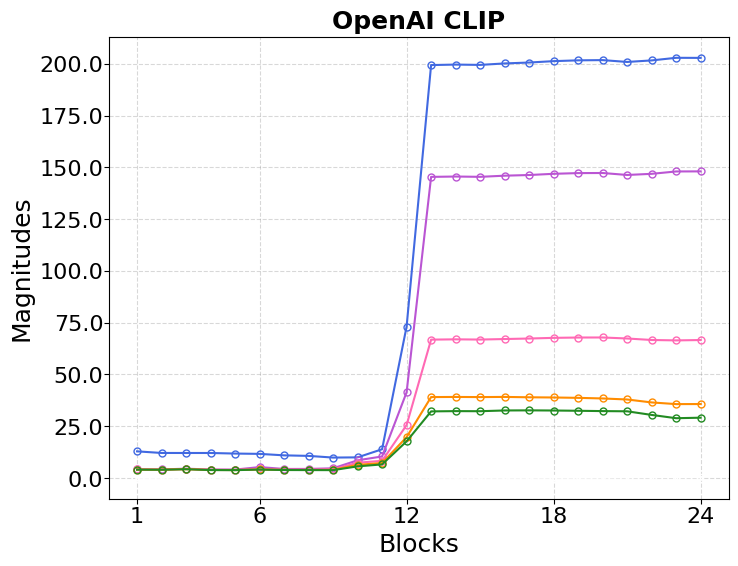

In [3]:
analyzer = ActivationsAnalyzer(model, dataset)
expressive_block = analyzer.analyze()

## 🛠️ Step 2: Train the Watermark Encoder and Decoder
Now that we have identified the expressive block, we embed the watermark by training two small networks:

- **Encoder**: Injects the binary message into the internal features of the expressive block.
- **Decoder**: Recovers the message from the output of the downstream layers.

During training, we freeze the backbone up to the expressive block and jointly optimize the encoder, decoder, and the tail of the model (from the expressive block onward).  
The objective is to **preserve model functionality** while enabling reliable watermark extraction.


In [4]:
wm_encoder, wm_decoder = create_wm_models(
    watermark_size=WATERMARK_SIZE,
    feature_dim=model.get_hidden_size()
)

trainer = ExpressPrintTrainer(
    model=model,
    wm_encoder=wm_encoder,
    wm_decoder=wm_decoder,
    wm_block_idx=expressive_block,
    log_path="../demos_logs/wm",
    num_epochs=5
)

train_loader = dataloader.get_train_loader(
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    train_transforms=train_transforms,
)
val_loader = dataloader.get_val_loader(
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    val_transforms=val_transform,
)
test_loader = dataloader.get_val_loader(
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    val_transforms=val_transform,
    return_path=True 
)

model, wm_encoder, wm_decoder = trainer.train(train_loader, val_loader, test_loader)

=> Logging in ../demos_logs/wm
TEST epoch: 4, step: 9 of 3125, loss: 0.02654406428337097432183838

Preparing Test Set: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 75.61samples/s]


✅ Saved 1000 samples to: ../demos_logs/wm/wm_test_set.json


## 🔐 Step 3: Watermark Injection and Verification (Single Image Demo)
In this step, we demonstrate how to use the trained watermarking modules to embed and extract a 32-bit binary message in a single image.

We use the `ExpressPrintWatermarker` class, which wraps the encoder, decoder, expressive block index, and the base model.  
It exposes two simple methods:

- `embed(image)` injects a watermark into the model using a forward pass over the given image;

- `extract()` retrieves the watermark from the internal representations after propagation.

We then compare the original and recovered message and compute the **bitwise distance** (number of mismatches).

In [5]:
img_path = "./assets/image_00.jpeg"  
image = val_transform(Image.open(img_path).convert("RGB")).unsqueeze(0).cuda()

wm = ExpressPrintWatermarker(
    model=model,
    encoder=wm_encoder,
    decoder=wm_decoder,
    wm_block_idx=expressive_block,
    wm_size=WATERMARK_SIZE
)

message = wm.embed(image)
recovered = wm.extract()

print("Original message: ", message.int().squeeze().tolist())
print("Recovered message:", recovered.squeeze().tolist())

bit_errors = (recovered.squeeze() != message.squeeze().int()).sum().item()
print(f"Bitwise distance: {bit_errors} / {WATERMARK_SIZE}")

Original message:  [0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]
Recovered message: [0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]
Bitwise distance: 0 / 32


## 🔄 Step 4: Fine-tuning and Watermark Robustness Evaluation
In this step, we fine-tune a pre-marked Vision Transformer (ViT) model on a downstream classification task to assess the robustness of the embedded watermark.

To simulate realistic deployment, the model-equipped with a new classification head — is trained using labeled samples from a different classification dataset. After fine-tuning, we verify whether the watermark remains detectable, confirming its persistence under standard transfer learning conditions.

We use our package's built-in experimental module to fine-tune a pre-marked Vision Transformer model on a new classification dataset. The following components are used:

- `create_model` instantiates the classifier with a modified architecture if needed.

- `DataLoader` handles loading and transforming images from the custom dataset.

- `Trainer` performs model fine-tuning and logs the results.

In [6]:
from expressprint.experiments.classification import DataLoader, Trainer, create_model

classifier = create_model(model=model.get_model(), num_classes=9)
dataloader = DataLoader(data_dir="../../data/ecommerce_product_images")

train_loader = dataloader.get_train_loader(
    batch_size=BATCH_SIZE * 2,
    num_workers=NUM_WORKERS,
    train_transforms=train_transforms,
)
val_loader = dataloader.get_val_loader(
    batch_size=BATCH_SIZE * 2,
    num_workers=NUM_WORKERS,
    val_transforms=val_transform,
)

trainer = Trainer(
    model=classifier,
    log_path="../demos_logs/ft",
    num_classes=9,
    num_epochs=5,
    lr=0.000001,
    lr_scheduler_params={"lr_peak_epoch": 3, "lr_peak": 0.00001},
)
trainer.train(train_loader, val_loader)

wm_dataset = WatermarkDataLoader(
    data_dir="../../imagenet/ILSVRC/Data/CLS-LOC",
    json_path="../demos_logs/wm/wm_test_set.json"
).get_val_loader(
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    val_transforms=val_transform,
)

=> Logging in ../demos_logs/ft
TEST epoch: 4, step: 113 of 114, loss: 0.5492358207702637652009343

Testing Watermark: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:11<00:00,  5.68it/s]



Accuracy by number of erroneous bits:
≤ Errors	Accuracy
≤ 0		99.90%
≤ 1		100.00%
≤ 2		100.00%
≤ 3		100.00%
≤ 4		100.00%
≤ 5		100.00%
≤ 6		100.00%
≤ 7		100.00%


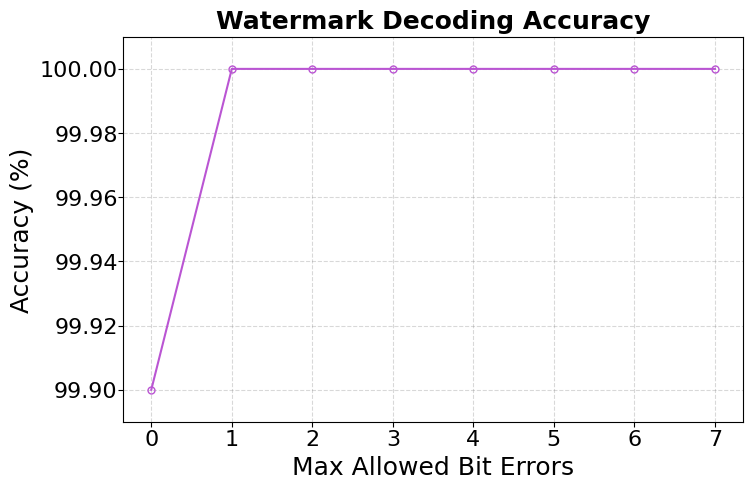

In [7]:
# === Positive Suspect ===

model.model = classifier
wm = ExpressPrintWatermarker(
    model=model,
    encoder=wm_encoder,
    decoder=wm_decoder,
    wm_block_idx=expressive_block,
    wm_size=WATERMARK_SIZE
)

wm.evaluate(wm_dataset)

Testing Watermark: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:11<00:00,  5.70it/s]



Accuracy by number of erroneous bits:
≤ Errors	Accuracy
≤ 0		0.00%
≤ 1		0.00%
≤ 2		0.00%
≤ 3		0.00%
≤ 4		0.00%
≤ 5		0.10%
≤ 6		0.20%
≤ 7		0.20%


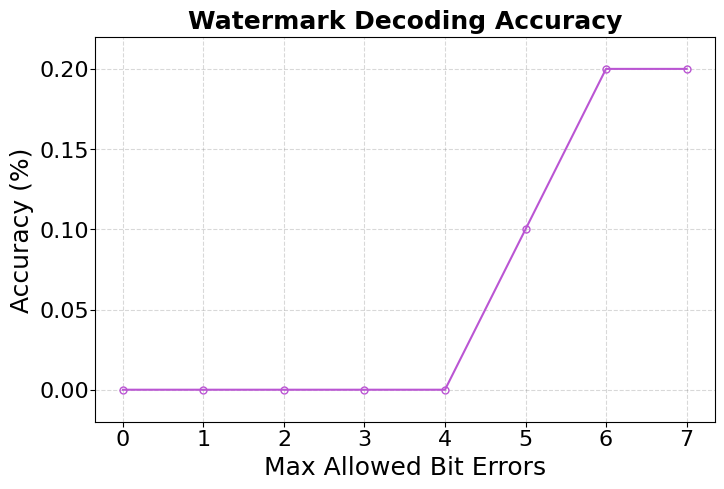

In [8]:
# === Negative Suspect ===


wm = ExpressPrintWatermarker(
    model=CLIPModel(),
    encoder=wm_encoder,
    decoder=wm_decoder,
    wm_block_idx=expressive_block,
    wm_size=WATERMARK_SIZE
)

wm.evaluate(wm_dataset)